# Parameter estimation of Lotka Volterra model using optimisation methods
# Lotka-Volterra Parameter Estimation Benchmarks
### Vaibhav Dixit, Chris Rackauckas

In [2]:
using ParameterizedFunctions, OrdinaryDiffEq, DiffEqParamEstim, LinearAlgebra
using BlackBoxOptim, NLopt, Plots, RecursiveArrayTools #, QuadDIRECT
gr(fmt=:png)

Plots.GRBackend()

In [3]:
loc_bounds = Tuple{Float64, Float64}[(0, 5), (0, 5), (0, 5), (0, 5)]
glo_bounds = Tuple{Float64, Float64}[(0, 10), (0, 10), (0, 10), (0, 10)]
loc_init = [1,0.5,3.5,1.5]
glo_init = [5,5,5,5]

4-element Array{Int64,1}:
 5
 5
 5
 5

In [4]:
f = @ode_def LotkaVolterraTest begin
    dx = a*x - b*x*y
    dy = -c*y + d*x*y
end a b c d

notime_tgrad = ModelingToolkit.Constant[ModelingToolkit.Constant(0), ModelingToolkit.Constant(0)]
tgrad = ModelingToolkit.Constant[ModelingToolkit.Constant(0), ModelingToolkit.Constant(0)]


(::LotkaVolterraTest{var"###ParameterizedDiffEqFunction#445",var"###ParameterizedTGradFunction#446",var"###ParameterizedJacobianFunction#447",Nothing,Nothing,ModelingToolkit.ODESystem}) (generic function with 1 method)

In [5]:
u0 = [1.0,1.0]                          #initial values
tspan = (0.0,10.0)
p = [1.5,1.0,3.0,1,0]                   #parameters used, these need to be estimated from the data
tspan = (0.0, 30.0)                     # sample of 3000 observations over the (0,30) timespan
prob = ODEProblem(f, u0, tspan,p)
tspan2 = (0.0, 3.0)                     # sample of 3000 observations over the (0,30) timespan
prob_short = ODEProblem(f, u0, tspan2,p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 3.0)
u0: [1.0, 1.0]

In [6]:
dt = 30.0/3000
tf = 30.0
tinterval = 0:dt:tf
t  = collect(tinterval)

3001-element Array{Float64,1}:
  0.0 
  0.01
  0.02
  0.03
  0.04
  0.05
  0.06
  0.07
  0.08
  0.09
  0.1 
  0.11
  0.12
  ⋮   
 29.89
 29.9 
 29.91
 29.92
 29.93
 29.94
 29.95
 29.96
 29.97
 29.98
 29.99
 30.0 

In [7]:
h = 0.01
M = 300
tstart = 0.0
tstop = tstart + M * h
tinterval_short = 0:h:tstop
t_short = collect(tinterval_short)

301-element Array{Float64,1}:
 0.0 
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1 
 0.11
 0.12
 ⋮   
 2.89
 2.9 
 2.91
 2.92
 2.93
 2.94
 2.95
 2.96
 2.97
 2.98
 2.99
 3.0 

In [8]:
#Generate Data
data_sol_short = solve(prob_short,Tsit5(),saveat=t_short,reltol=1e-9,abstol=1e-9)
data_short = convert(Array, data_sol_short)
data_sol = solve(prob,Tsit5(),saveat=t,reltol=1e-9,abstol=1e-9)
data = convert(Array, data_sol)

2×3001 Array{Float64,2}:
 1.0  1.00511   1.01045   1.01601   1.02179   …  1.07814   1.08595   1.09398 
 1.0  0.980224  0.960888  0.941986  0.923508     0.785597  0.770673  0.756092

#### Plot of the solution

##### Short Solution

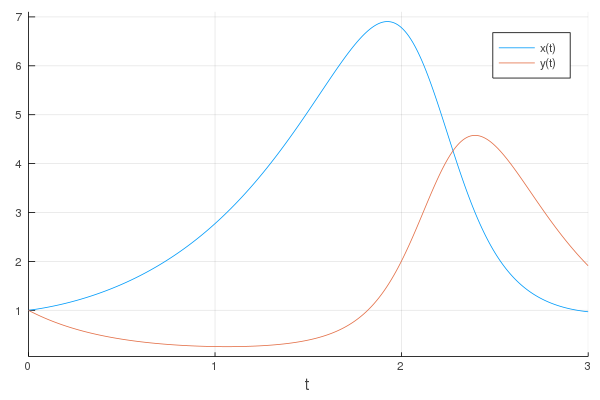

In [9]:
p1 = plot(data_sol_short)

##### Longer Solution

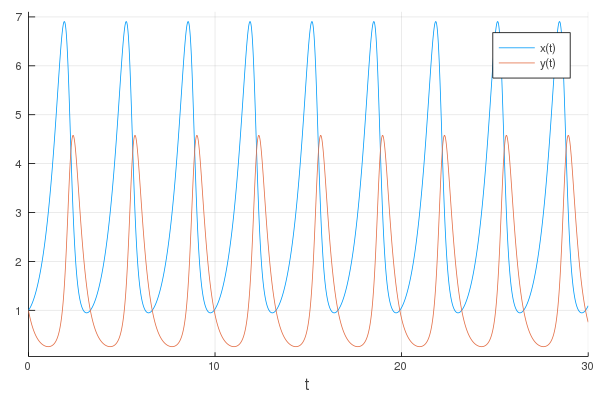

In [10]:
p2 = plot(data_sol)

### Local Solution from the short data set

In [11]:
obj_short = build_loss_objective(prob_short,Tsit5(),L2Loss(t_short,data_short),tstops=t_short)
res1 = bboptimize(obj_short;SearchRange = glo_bounds, MaxSteps = 7e3)
# Lower tolerance could lead to smaller fitness (more accuracy)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 2737 evals, 2613 steps, improv/step: 0.205 (last = 0.2047), fitness=53.737396127
1.00 secs, 5593 evals, 5470 steps, improv/step: 0.197 (last = 0.1901), fitness=0.138721946

Optimization stopped after 7001 steps and 1.26 seconds
Termination reason: Max number of steps (7000) reached
Steps per second = 5569.61
Function evals per second = 5667.46
Improvements/step = 0.19014
Total function evaluations = 7124


Best candidate found: [1.49849, 1.00036, 3.00804, 1.00253]

Fitness: 0.003429315



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (7000) reached", 7001, 1.584806328393e9, 1.257000207901001, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 44578,:SearchRange => Tuple{Float64,Float64}[(0.0, 10.0), (0.0, 10.0), (0.0, 10.0), (0.0, 10.0)],:MaxSteps => 7000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 7124, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(0.003429315316646572, [1.4984873486515715, 1.0003573237824641, 3.008043079564332, 1.0025286318302022]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([1.5003063578740348 1.4974475525189748 … 1.

In [12]:
obj_short = build_loss_objective(prob_short,Tsit5(),L2Loss(t_short,data_short),tstops=t_short,reltol=1e-9)
res1 = bboptimize(obj_short;SearchRange = glo_bounds, MaxSteps = 7e3)
# Change in tolerance makes it worse

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 3083 evals, 2971 steps, improv/step: 0.170 (last = 0.1696), fitness=51.252639682
1.00 secs, 6368 evals, 6257 steps, improv/step: 0.165 (last = 0.1616), fitness=0.063765117

Optimization stopped after 7001 steps and 1.13 seconds
Termination reason: Max number of steps (7000) reached
Steps per second = 6201.06
Function evals per second = 6298.49
Improvements/step = 0.16986
Total function evaluations = 7111


Best candidate found: [1.49982, 0.998836, 3.00052, 0.999963]

Fitness: 0.003236980



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (7000) reached", 7001, 1.5848064835e9, 1.128999948501587, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 901496,:SearchRange => Tuple{Float64,Float64}[(0.0, 10.0), (0.0, 10.0), (0.0, 10.0), (0.0, 10.0)],:MaxSteps => 7000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 7111, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(0.003236980132433737, [1.4998160835544596, 0.9988364016231133, 3.0005246291513537, 0.9999630057110312]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([1.4979939808597997 1.5034961421496733 … 1.

In [13]:
obj_short = build_loss_objective(prob_short,Vern9(),L2Loss(t_short,data_short),tstops=t_short,reltol=1e-9,abstol=1e-9)
res1 = bboptimize(obj_short;SearchRange = glo_bounds, MaxSteps = 7e3)
# using the moe accurate Vern9() reduces the fitness marginally and leads to some increase in time taken

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 2022 evals, 1901 steps, improv/step: 0.185 (last = 0.1852), fitness=160.403742247
1.00 secs, 4756 evals, 4635 steps, improv/step: 0.157 (last = 0.1375), fitness=3.706626762

Optimization stopped after 7001 steps and 1.45 seconds
Termination reason: Max number of steps (7000) reached
Steps per second = 4828.28
Function evals per second = 4911.03
Improvements/step = 0.16286
Total function evaluations = 7121


Best candidate found: [1.49889, 0.999291, 2.99943, 1.00081]

Fitness: 0.009641964



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (7000) reached", 7001, 1.584806496394e9, 1.4500000476837158, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 10765,:SearchRange => Tuple{Float64,Float64}[(0.0, 10.0), (0.0, 10.0), (0.0, 10.0), (0.0, 10.0)],:MaxSteps => 7000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 7121, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(0.00964196394657385, [1.4988865006457417, 0.9992911745749, 2.99943137916272, 1.0008060176885967]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([1.5005235517390434 1.5113289222406625 … 1.4998

# Using NLopt

#### Global Optimisation first

In [14]:
obj_short = build_loss_objective(prob_short,Vern9(),L2Loss(t_short,data_short),tstops=t_short,reltol=1e-9,abstol=1e-9)

(::DiffEqObjective{DiffEqParamEstim.var"#43#48"{Nothing,Bool,Int64,typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR),Base.Iterators.Pairs{Symbol,Any,Tuple{Symbol,Symbol,Symbol},NamedTuple{(:tstops, :reltol, :abstol),Tuple{Array{Float64,1},Float64,Float64}}},ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},LotkaVolterraTest{var"###ParameterizedDiffEqFunction#445",var"###ParameterizedTGradFunction#446",var"###ParameterizedJacobianFunction#447",Nothing,Nothing,ModelingToolkit.ODESystem},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},DiffEqBase.StandardODEProblem},Vern9,L2Loss{Array{Float64,1},Array{Float64,2},Nothing,Nothing,Nothing},Nothing},DiffEqParamEstim.var"#47#53"{DiffEqParamEstim.var"#43#48"{Nothing,Bool,Int64,typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR),Base.Iterators.Pairs{Symbol,Any,Tuple{Symbol,Symbol,Symbol},NamedTuple{(:tstops, :reltol, :abstol),Tuple{Array{Float64,1},Float64,Float64}}},ODEProblem{Array{Float64,1},Tuple{Float6

In [15]:
opt = Opt(:GN_ORIG_DIRECT_L, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[10.0,10.0,10.0,10.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,glo_init)

  0.722303 seconds (1.62 M allocations: 378.377 MiB, 6.14% gc time)


(368.38768828453067, [1.7283950617224937, 2.22222222222419, 3.580246913586148, 1.1172077427280471], :XTOL_REACHED)

In [16]:
opt = Opt(:GN_CRS2_LM, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[10.0,10.0,10.0,10.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,glo_init)

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase C:\Users\aless\.julia\packages\DiffEqBase\ytZvl\src\integrator_interface.jl:329
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Users\aless\.julia\packages\DiffEqBase\ytZvl\src\integrator_interface.jl:343
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Users\aless\.julia\packages\DiffEqBase\ytZvl\src\integrator_interface.jl:343


  1.666629 seconds (3.20 M allocations: 742.612 MiB, 4.37% gc time)


┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Users\aless\.julia\packages\DiffEqBase\ytZvl\src\integrator_interface.jl:343


(1.6661036081622402e-16, [1.5000000000703442, 1.0000000000851745, 2.9999999995066617, 0.9999999999249853], :XTOL_REACHED)

In [17]:
opt = Opt(:GN_ISRES, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[10.0,10.0,10.0,10.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,glo_init)

  1.737955 seconds (4.09 M allocations: 966.263 MiB, 4.72% gc time)


(20.6620999220374, [1.3544655998121184, 0.9464301921767058, 3.739865058351026, 1.271820068469745], :MAXEVAL_REACHED)

In [18]:
opt = Opt(:GN_ESCH, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[10.0,10.0,10.0,10.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,glo_init)

  1.748317 seconds (4.09 M allocations: 966.263 MiB, 4.64% gc time)


(332.3017635736973, [2.779662439085016, 1.56656526380548, 0.4348506362471559, 0.22242373044882147], :MAXEVAL_REACHED)

Now local optimization algorithms are used to check the global ones, these use the local constraints, different intial values and time step

In [19]:
opt = Opt(:LN_BOBYQA, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[5.0,5.0,5.0,5.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,loc_init)

  0.076711 seconds (149.68 k allocations: 34.355 MiB, 9.78% gc time)


(1.666092563977136e-16, [1.5000000000701428, 1.0000000000847955, 2.9999999995083857, 0.9999999999254293], :XTOL_REACHED)

In [20]:
opt = Opt(:LN_NELDERMEAD, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[5.0,5.0,5.0,5.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,loc_init)

  0.095122 seconds (205.96 k allocations: 48.468 MiB, 7.59% gc time)


(1.6660944511624276e-16, [1.5000000000705116, 1.0000000000852818, 2.999999999507228, 0.9999999999250377], :XTOL_REACHED)

In [21]:
opt = Opt(:LD_SLSQP, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[5.0,5.0,5.0,5.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,loc_init)

  0.075775 seconds (215.05 k allocations: 31.682 MiB)


(4.1924234229837273e-16, [1.499999999682718, 1.0000000001713023, 3.000000002088545, 1.0000000007284087], :XTOL_REACHED)

In [22]:
opt = Opt(:LN_COBYLA, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[5.0,5.0,5.0,5.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,loc_init)

  1.737074 seconds (4.09 M allocations: 966.263 MiB, 4.85% gc time)


(2.9425218477347897e-10, [1.4999993919433179, 0.999999828183019, 3.0000031388881534, 1.000000991049925], :MAXEVAL_REACHED)

In [23]:
opt = Opt(:LN_NEWUOA_BOUND, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[5.0,5.0,5.0,5.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,loc_init)

  0.192064 seconds (171.38 k allocations: 40.487 MiB)


(3.981047760797371e-9, [1.4999997334324482, 0.9999983950625567, 2.9999986492377673, 0.9999999903184932], :SUCCESS)

In [24]:
opt = Opt(:LN_PRAXIS, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[5.0,5.0,5.0,5.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,loc_init)

  0.046016 seconds (87.95 k allocations: 20.775 MiB, 17.67% gc time)


(1.666352759770978e-16, [1.500000000065296, 1.0000000000836613, 2.999999999537112, 0.999999999933874], :SUCCESS)

In [25]:
opt = Opt(:LN_SBPLX, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[5.0,5.0,5.0,5.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,loc_init)

  1.728400 seconds (4.09 M allocations: 966.263 MiB, 4.32% gc time)


(3.857624483458146e-12, [1.4999999301104459, 0.9999999814386067, 3.000000353466034, 1.0000001103210938], :MAXEVAL_REACHED)

In [26]:
opt = Opt(:LD_MMA, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[5.0,5.0,5.0,5.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,loc_init)

  3.581390 seconds (8.55 M allocations: 1.977 GiB, 4.41% gc time)


(3.3388978586808943e-15, [1.4999999981370287, 0.999999999704403, 3.0000000098642663, 1.0000000031859053], :XTOL_REACHED)

In [27]:
opt = Opt(:LD_TNEWTON_PRECOND_RESTART, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[5.0,5.0,5.0,5.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,loc_init)

  0.065351 seconds (146.85 k allocations: 34.763 MiB, 9.31% gc time)


(4.192411353203476e-16, [1.4999999996827071, 1.0000000001712896, 3.0000000020885786, 1.0000000007284184], :SUCCESS)

## Now the longer problem is solved for a global solution

Vern9 solver with reltol=1e-9 and abstol=1e-9 is used and the dataset is increased to 3000 observations per variable with the same integration time step of 0.01.

In [28]:
obj = build_loss_objective(prob,Vern9(),L2Loss(t,data),tstops=t,reltol=1e-9,abstol=1e-9)
res1 = bboptimize(obj;SearchRange = glo_bounds, MaxSteps = 4e3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 299 evals, 210 steps, improv/step: 0.386 (last = 0.3857), fitness=22321.237247745
1.00 secs, 598 evals, 492 steps, improv/step: 0.309 (last = 0.2518), fitness=22321.237247745
1.51 secs, 901 evals, 786 steps, improv/step: 0.270 (last = 0.2041), fitness=22321.237247745
2.01 secs, 1202 evals, 1082 steps, improv/step: 0.238 (last = 0.1520), fitness=22321.237247745
2.51 secs, 1488 evals, 1358 steps, improv/step: 0.211 (last = 0.1051), fitness=16765.309913385
3.01 secs, 1782 evals, 1642 steps, improv/step: 0.195 (last = 0.1232), fitness=16765.309913385
3.51 secs, 2072 evals, 1927 steps, improv/step: 0.181 (last = 0.0947), fitness=16765.309913385
4.01 secs, 2369 evals, 2223 steps, improv/step: 0.170 (last = 0.0980), fitness=15717.211960106
4.51 secs, 2651 evals, 2501 steps, improv/ste

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (4000) reached", 4001, 1.584806592291e9, 7.01800012588501, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 347492,:SearchRange => Tuple{Float64,Float64}[(0.0, 10.0), (0.0, 10.0), (0.0, 10.0), (0.0, 10.0)],:MaxSteps => 4000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 4164, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(11436.34246325503, [5.482690199264583, 6.1584857475691095, 0.7491138387680273, 0.2784417016751761]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([9.862809028426062 8.383181783146282 … 9.21575

In [ ]:
opt = Opt(:GN_ORIG_DIRECT_L, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[10.0,10.0,10.0,10.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,glo_init)

In [ ]:
opt = Opt(:GN_CRS2_LM, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[10.0,10.0,10.0,10.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 20000)
@time (minf,minx,ret) = NLopt.optimize(opt,glo_init)

In [ ]:
opt = Opt(:GN_ISRES, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[10.0,10.0,10.0,10.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 50000)
@time (minf,minx,ret) = NLopt.optimize(opt,glo_init)

In [ ]:
opt = Opt(:GN_ESCH, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[10.0,10.0,10.0,10.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 20000)
@time (minf,minx,ret) = NLopt.optimize(opt,glo_init)

In [ ]:
opt = Opt(:LN_BOBYQA, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[5.0,5.0,5.0,5.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,loc_init)

In [ ]:
opt = Opt(:LN_NELDERMEAD, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[5.0,5.0,5.0,5.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-9)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,loc_init)

In [ ]:
opt = Opt(:LD_SLSQP, 4)
lower_bounds!(opt,[0.0,0.0,0.0,0.0])
upper_bounds!(opt,[5.0,5.0,5.0,5.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,loc_init)

#### Using QuadDIRECT

In [ ]:
obj_short = build_loss_objective(prob_short,Tsit5(),L2Loss(t_short,data_short),tstops=t_short)
lower = [0.0,0.0,0.0,0.0]
upper = [5.0,5.0,5.0,5.0]
splits = ([0.0,1.0,3.0],[0.0,1.0,3.0],[0.0,1.0,3.0],[0.0,1.0,3.0])
root, x0 = analyze(obj_short,splits,lower,upper)

In [ ]:
minimum(root)

In [ ]:
obj = build_loss_objective(prob,Vern9(),L2Loss(t,data),tstops=t,reltol=1e-9,abstol=1e-9)
lower = [0.0,0.0,0.0,0.0]
upper = [10.0,10.0,10.0,10.0]
splits = ([0.0,3.0,6.0],[0.0,3.0,6.0],[0.0,3.0,6.0],[0.0,3.0,6.0])
root, x0 = analyze(obj,splits,lower,upper)

In [ ]:
minimum(root)

#### Parameter estimation on the longer sample proves to be extremely challenging for some of the global optimizers. A few give the accurate values, BlacBoxOptim also performs quite well while others seem to struggle with accuracy a lot.

# Conclusion

In general we observe that lower tolerance lead to higher accuracy but too low tolerance could affect the convergance time drastically. Also fitting a shorter timespan seems to be easier in comparision (quite intutively). NLOpt methods seem to give great accuracy in the shorter problem with a lot of the algorithms giving 0 fitness, BBO performs very well on it with marginal change with `tol` values. In case of global optimization of the longer problem  there is some difference in the perfomance amongst the algorithms with `LD_SLSQP` `GN_ESCH` `GN_ISRES` `GN_ORIG_DIRECT_L` performing among the worse, BBO also gives a bit high fitness in comparison. QuadDIRECT gives accurate results in the case of the shorter problem but doesn't perform very well in the longer problem case.